# 0. Imports 

In [119]:
import math
import random
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import statsmodels.api as sm

from os import listdir
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import svm, tree
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier

from boruta import BorutaPy
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler


# 1.0 Data Loading 

In [2]:
data_path = '../datasets/'
files = listdir(data_path)

full = files[1]
stats = files[2]

## 1.1 Partidas

In [3]:
df_full = pd.read_csv(data_path + full)
df_full.head()

,ID,rodada,data,hora,dia,mandante,visitante,formacao_mandante,formacao_visitante,tecnico_mandante,tecnico_visitante,vencedor,arena,mandante_placar,visitante_placar,mandante_estado,visitante_estado,estado_vencedor
0,1,1,2003-03-29,16:00,Sabado,Guarani,Vasco,NaN,NaN,NaN,NaN,Guarani,brinco de ouro,4,2,SP,RJ,SP
1,2,1,2003-03-29,16:00,Sabado,Athletico-PR,Gremio,NaN,NaN,NaN,NaN,Athletico-PR,arena da baixada,2,0,PR,RS,PR
2,3,1,2003-03-30,16:00,Domingo,Flamengo,Coritiba,NaN,NaN,NaN,NaN,-,maracana,1,1,RJ,PR,-
3,4,1,2003-03-30,16:00,Domingo,Goias,Paysandu,NaN,NaN,NaN,NaN,-,serra dourada,2,2,GO,PA,-
4,5,1,2003-03-30,16:00,Domingo,Internacional,Ponte Preta,NaN,NaN,NaN,NaN,-,beira rio,1,1,RS,SP,-


In [4]:
print(f'O número de linhas (exemplos) é {df_full.shape[0]} e de colunas (atributos) é {df_full.shape[1]}.')

O número de linhas (exemplos) é 7645 e de colunas (atributos) é 18.


In [5]:
df_full.dtypes

ID                     int64
rodada                 int64
data                  object
hora                  object
dia                   object
mandante              object
visitante             object
formacao_mandante     object
formacao_visitante    object
tecnico_mandante      object
tecnico_visitante     object
vencedor              object
arena                 object
mandante_placar        int64
visitante_placar       int64
mandante_estado       object
visitante_estado      object
estado_vencedor       object
dtype: object

## 1.2  Estatísticas

In [6]:
df_stats = pd.read_csv(data_path + stats)
df_stats.head()

,partida_id,rodada,clube,chutes,chutes_no_alvo,posse_de_bola,passes,precisao_passes,faltas,cartao_amarelo,cartao_vermelho,impedimentos,escanteios
0,1,1,Guarani,0,0,NaN,0,NaN,0,0,0,0,0
1,1,1,Vasco,0,0,NaN,0,NaN,0,0,0,0,0
2,2,1,Athletico-PR,0,0,NaN,0,NaN,0,0,0,0,0
3,2,1,Gremio,0,0,NaN,0,NaN,0,0,0,0,0
4,3,1,Flamengo,0,0,NaN,0,NaN,0,0,0,0,0


In [7]:
print(f'O número de linhas (exemplos) é {df_stats.shape[0]} e de colunas (atributos) é {df_stats.shape[1]}.')

O número de linhas (exemplos) é 15290 e de colunas (atributos) é 13.


In [8]:
df_stats.dtypes

partida_id          int64
rodada              int64
clube              object
chutes              int64
chutes_no_alvo      int64
posse_de_bola      object
passes              int64
precisao_passes    object
faltas              int64
cartao_amarelo      int64
cartao_vermelho     int64
impedimentos        int64
escanteios          int64
dtype: object

# 2.0 Data Cleaning 

In [9]:
# uma copia para facilitar recuperar os dados
df2_full = df_full.copy()
df2_stats = df_stats.copy()

## 2.1 Funções Úteis

In [10]:
def season(row):
    """
    Indica qual a temporada do campeonato, considerando o efeito da pandemia na temporada de 2020
    """
    if row['data'] <= pd.to_datetime('2021-02-25', yearfirst=True):
        if row['data'].year != 2021:
            return row['data'].year
        else:
            return row['data'].year - 1
    else:
        return row['data'].year

## 2.2  Dataframe de Partidas

In [11]:
# indicando qual a temporada do campeonato
df2_full.loc[:, 'data'] = pd.to_datetime(df2_full.data, yearfirst=True)    
df2_full.insert(4, 'temporada', df2_full.apply(season, axis = 1))
df2_full.head()

,ID,rodada,data,hora,temporada,dia,mandante,visitante,formacao_mandante,formacao_visitante,tecnico_mandante,tecnico_visitante,vencedor,arena,mandante_placar,visitante_placar,mandante_estado,visitante_estado,estado_vencedor
0,1,1,2003-03-29,16:00,2003,Sabado,Guarani,Vasco,NaN,NaN,NaN,NaN,Guarani,brinco de ouro,4,2,SP,RJ,SP
1,2,1,2003-03-29,16:00,2003,Sabado,Athletico-PR,Gremio,NaN,NaN,NaN,NaN,Athletico-PR,arena da baixada,2,0,PR,RS,PR
2,3,1,2003-03-30,16:00,2003,Domingo,Flamengo,Coritiba,NaN,NaN,NaN,NaN,-,maracana,1,1,RJ,PR,-
3,4,1,2003-03-30,16:00,2003,Domingo,Goias,Paysandu,NaN,NaN,NaN,NaN,-,serra dourada,2,2,GO,PA,-
4,5,1,2003-03-30,16:00,2003,Domingo,Internacional,Ponte Preta,NaN,NaN,NaN,NaN,-,beira rio,1,1,RS,SP,-


In [12]:
df2_full.groupby('temporada')['rodada'].max()

temporada
2003    46
2004    46
2005    42
2006    38
2007    38
2008    38
2009    38
2010    38
2011    38
2012    38
2013    38
2014    38
2015    38
2016    38
2017    38
2018    38
2019    38
2020    38
2021    38
Name: rodada, dtype: int64

In [13]:
df2_full.groupby('temporada')['rodada'].count()

temporada
2003    552
2004    552
2005    462
2006    380
2007    380
2008    380
2009    380
2010    380
2011    380
2012    380
2013    380
2014    380
2015    380
2016    379
2017    380
2018    380
2019    380
2020    380
2021    380
Name: rodada, dtype: int64

<b> Constatações <b>
- Em 2005 foram 42 rodadas com 11 jogos cada, pois era outro formato de campeonato; 
- A temporada 2016 teve um jogo a menos

## 2.3 Dataframe de Estatísticas

In [14]:
# renomeando a coluna para ficar compatível com df_full
df2_stats = df2_stats.rename(columns = {'partida_id': 'ID'})

In [15]:
# como df_stats2 nao tem a data, sera inlcuida
df2_stats = pd.merge(df2_stats, df2_full[['ID','data']], on='ID')

In [16]:
# incluindo a temporada
df2_stats.loc[:, 'temporada'] = df2_stats.apply(season, axis = 1)

In [17]:
columns_new_order = ['ID',
                     'temporada',
                     'rodada',
                     'data',
                     'clube',
                     'chutes',                     
                     'chutes_no_alvo',
                     'posse_de_bola',
                     'passes',
                     'precisao_passes',
                     'faltas',
                     'cartao_amarelo',
                     'cartao_vermelho',
                     'impedimentos',
                     'escanteios']
df2_stats = df2_stats[columns_new_order]

In [18]:
df2_stats.head()

,ID,temporada,rodada,data,clube,chutes,chutes_no_alvo,posse_de_bola,passes,precisao_passes,faltas,cartao_amarelo,cartao_vermelho,impedimentos,escanteios
0,1,2003,1,2003-03-29,Guarani,0,0,NaN,0,NaN,0,0,0,0,0
1,1,2003,1,2003-03-29,Vasco,0,0,NaN,0,NaN,0,0,0,0,0
2,2,2003,1,2003-03-29,Athletico-PR,0,0,NaN,0,NaN,0,0,0,0,0
3,2,2003,1,2003-03-29,Gremio,0,0,NaN,0,NaN,0,0,0,0,0
4,3,2003,1,2003-03-30,Flamengo,0,0,NaN,0,NaN,0,0,0,0,0


Checando variáveis com muitos zeros

In [19]:
df2_stats.groupby('temporada').sum()['passes']

temporada
2003         0
2004         0
2005         0
2006         0
2007         0
2008         0
2009         0
2010         0
2011         0
2012         0
2013         0
2014     13087
2015    315861
2016    313276
2017    320578
2018    324116
2019    301837
2020    325403
2021    323609
Name: passes, dtype: int64

In [20]:
df2_stats.groupby('temporada').sum()['chutes']

temporada
2003       0
2004       0
2005       0
2006       0
2007       0
2008       0
2009       0
2010       0
2011       0
2012       0
2013       0
2014     391
2015    9290
2016    9494
2017    9678
2018    9599
2019    9692
2020    9566
2021    9659
Name: chutes, dtype: int64

In [21]:
df2_stats.groupby('temporada').sum()['cartao_amarelo']

temporada
2003       0
2004       0
2005       0
2006       0
2007       0
2008       0
2009       0
2010       0
2011       0
2012       0
2013       0
2014      68
2015    1824
2016    1693
2017    1773
2018    1814
2019    1534
2020    1630
2021    1680
Name: cartao_amarelo, dtype: int64

In [22]:
df2_stats.groupby('temporada').sum()['cartao_vermelho']

temporada
2003      0
2004      0
2005      0
2006      0
2007      0
2008      0
2009      0
2010      0
2011      0
2012      0
2013      0
2014      0
2015    109
2016     86
2017     77
2018    101
2019     95
2020    106
2021     81
Name: cartao_vermelho, dtype: int64

In [23]:
df2_stats.groupby('temporada').sum()['impedimentos']

temporada
2003       0
2004       0
2005       0
2006       0
2007       0
2008       0
2009       0
2010       0
2011       0
2012       0
2013       0
2014      63
2015    1593
2016    1490
2017    1298
2018    1126
2019     945
2020    1129
2021    1040
Name: impedimentos, dtype: int64

In [24]:
df2_stats.groupby('temporada').sum()['escanteios']

temporada
2003       0
2004       0
2005       0
2006       0
2007       0
2008       0
2009       0
2010       0
2011       0
2012       0
2013       0
2014     183
2015    3923
2016    3870
2017    4044
2018    4054
2019    3733
2020    3854
2021    3878
Name: escanteios, dtype: int64

Nota-se que algumas variáveis estão sem dados coerentes para temporadas anteriores à 2015. Apesar destas variáveis serem obtidas apenas após o jogo, será possível utilizar um modelo para estimar o número de chutes, por exemplo.

## 2.3 Filtrando as temporadas

In [25]:
# Filtrando a partir de 2015
df2_full = df2_full[df2_full.temporada >= 2015].reset_index(drop=True)

In [26]:
print('O primeiro ID das partidas desde 2015 é:', df2_full.loc[0,'ID'])

O primeiro ID das partidas desde 2015 é: 4987


In [27]:
# Entao servira como filtro
df2_stats = df2_stats[df2_stats.ID >= df2_full.loc[0,'ID']]

## 2.4 Verificando NaN

In [28]:
print('% of NaN')
df2_full.isna().sum() / len(df2_full)

% of NaN


ID                    0.000000
rodada                0.000000
data                  0.000000
hora                  0.000000
temporada             0.000000
dia                   0.000000
mandante              0.000000
visitante             0.000000
formacao_mandante     0.001504
formacao_visitante    0.001504
tecnico_mandante      0.000376
tecnico_visitante     0.000376
vencedor              0.000000
arena                 0.000000
mandante_placar       0.000000
visitante_placar      0.000000
mandante_estado       0.000000
visitante_estado      0.000000
estado_vencedor       0.000000
dtype: float64

<b>df2_full</b>
- formacao_mandante e formacao_visitante = 4 partidas com NaN
- tecnico_mandante e tecnico_visitante = 1 partida com NaN

In [29]:
print('% of NaN')
df2_stats.isna().sum() / len(df2_stats)

% of NaN


ID                 0.0
temporada          0.0
rodada             0.0
data               0.0
clube              0.0
chutes             0.0
chutes_no_alvo     0.0
posse_de_bola      0.0
passes             0.0
precisao_passes    0.0
faltas             0.0
cartao_amarelo     0.0
cartao_vermelho    0.0
impedimentos       0.0
escanteios         0.0
dtype: float64

<b>df2_stats</b>
- sem partidas com NaN

In [30]:
print(f'O número de jogos é {len(df2_full)} e o número de jogos com estatísticas  é {int(len(df2_stats)/2)}')

O número de jogos é 2659 e o número de jogos com estatísticas  é 2659


<b> Todos os jogos tem estatísticas! </b>

# 3.0 Exploratory Data Analysis

In [31]:
df3_full = df2_full.copy()
df3_stats = df2_stats.copy()

A ideia aqui é tentar adquirir algum conhecimento das variáveis que possa ajudar a identificar as melhores features e modelos que possam ser utilizados posteriormente. Também são geradas algumas hipóteses com base nestas análises.

## 3.1 Funções Úteis

In [32]:
def encode_target(row):
    """
    Tranforma os resultados com base no vencedor, seguindo:
    0 - empate
    1 - mandante
    2 - visitante
    """
    if row['mandante'] == row['vencedor']:
        return 1
    elif row['visitante'] == row['vencedor']:
        return 2
    else:
        return 0

## 3.1 Vencedor Mandante x Visitante x Empate

In [33]:
# encoding na variavel do vencedor para facilitar algumas analises
df3_full['vencedor'] = df3_full.apply(encode_target, axis = 1)    

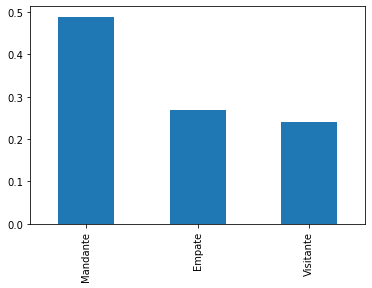

In [34]:
df3_full.vencedor.value_counts(normalize=True).plot(kind='bar');
plt.xticks(ticks=[0, 1, 2], labels=['Mandante', 'Empate', 'Visitante']);

<b> Constatações </b>
- A maioria dos jogos é vencida pelo mandante; 
- Os visitantes vencem na menor frequência

## 3.2 Resultados dos Dia da Semana

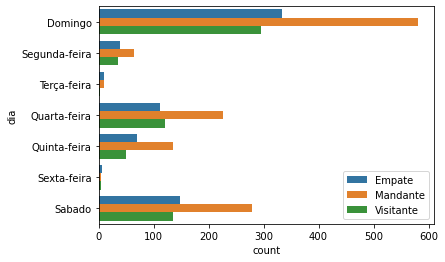

In [35]:
sns.countplot(y=df3_full.dia, hue=df3_full.vencedor, order=['Domingo', 'Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira', 'Sabado']);
plt.legend(['Empate', 'Mandante', 'Visitante']);

<b> Constatações </b>
- Visualmente não há diferença no efeito mandante x visitante em diferentes dias da semana;
- A única exceção é a segunda-feira, mas não foi feita análise da significância desta diferença;

## 3.3 Vencedor por Estado

In [36]:
df_aux = df3_full[['temporada', 'mandante', 'mandante_estado']]
df_aux2 = pd.DataFrame(pd.DataFrame(df_aux.groupby(['temporada', 'mandante_estado']).value_counts()).drop(0, axis = 1).groupby(['temporada', 'mandante_estado']).value_counts(), columns=['counts'])
df_aux2 = df_aux2.reset_index()

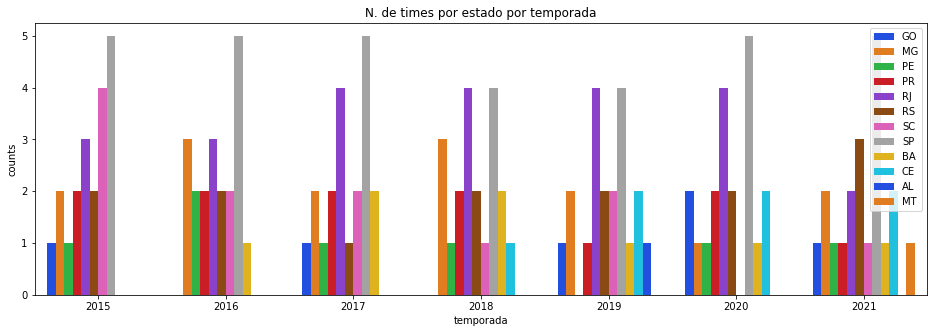

In [37]:
plt.figure(figsize=(16,5));
sns.barplot(x=df_aux2.temporada, y=df_aux2.counts, hue=df_aux2.mandante_estado, palette='bright');
plt.legend();
plt.title('N. de times por estado por temporada');

<b> Constatações </b>
- SP e RJ são os estados com maior quantidades de times na série A;
- RS, e SC se alternam na terceira colocação;
- No geral, a maioria dos estados tem entre 1 e 2 times na série A; 

### 3.3.1 Vencedores por Estado x Tempo

Para avaliar os times que mais venceram por temporada, é mais coerente apresentar a relação entre n. de vitorias / n. de times, já que a distribuição da quantidade destes não é homogênea.

In [38]:
df_aux2 = df_aux2.set_index(['temporada', 'mandante_estado'])
df_aux2 = df_aux2.rename(columns={'counts': 'contagem_de_times'})

df_aux3 = pd.DataFrame(pd.DataFrame(df3_full[df3_full['estado_vencedor'] != '-'][['temporada', 'estado_vencedor']] \
                                    .value_counts(), columns=['contagem_vitoria']).groupby(['temporada', 'estado_vencedor']) \
                                    .value_counts()).drop(0, axis = 1) \
                                    .reset_index(['contagem_vitoria'])

df_aux4 = pd.concat([df_aux2, df_aux3], axis = 1)
df_aux4.loc[:, 'vitorias_por_times'] = df_aux3.contagem_vitoria / df_aux4.contagem_de_times

In [39]:
df_aux4 = df_aux4.reset_index()
df_aux4 = df_aux4.rename(columns={'level_1': 'time'})
df_aux4.sort_values('vitorias_por_times', ascending=False).head(10)

,temporada,time,contagem_de_times,contagem_vitoria,vitorias_por_times
47,2020,MG,1,20,20.0
56,2021,MG,2,39,19.5
43,2019,SP,4,74,18.5
31,2018,RS,2,37,18.5
5,2015,RS,2,37,18.5
22,2017,RS,1,18,18.0
15,2016,SP,5,90,18.0
39,2019,PR,1,18,18.0
1,2015,MG,2,36,18.0
60,2021,RJ,2,36,18.0


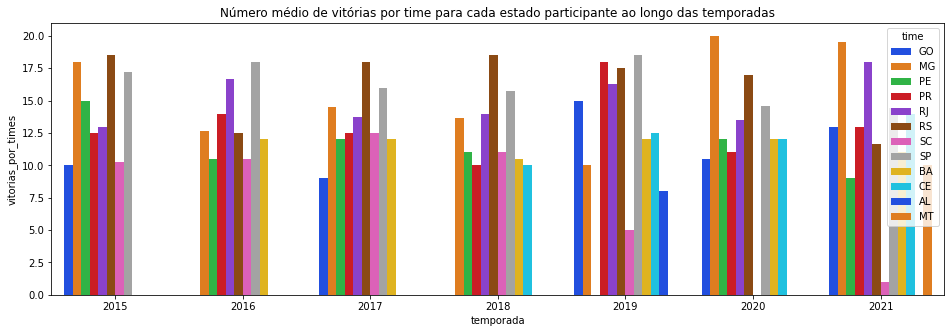

In [40]:
plt.figure(figsize=(16, 5));
sns.barplot(x=df_aux4['temporada'], y=df_aux4['vitorias_por_times'], hue=df_aux4['time'], palette='bright');
plt.title('Número médio de vitórias por time para cada estado participante ao longo das temporadas');

<b> Constatações </b>
- MG aparece como o estado mais vitorioso nos últimos 2 anos da série e também com um pico na relação em 2014;
- SP mesmo com a racionalização dos valores, ainda é um dos estados mais vitoriosos;
- RS aparece com uma proporção mais homogênea e ao longo do tempo;
- O número médio de vitórias por time de cada estado mostra uma alternância entre SP, MG, RS e RJ na primeira posição.

### 3.3.2 Estados Mais Vitoriosos

In [41]:
df_aux5 = df_aux4.groupby('time').sum().drop('vitorias_por_times', axis = 1)
df_aux5.loc[:, 'vitorias_por_times'] = df_aux5.contagem_vitoria / df_aux5.contagem_de_times
df_aux5 = df_aux5.reset_index().drop(['temporada'], axis = 1)

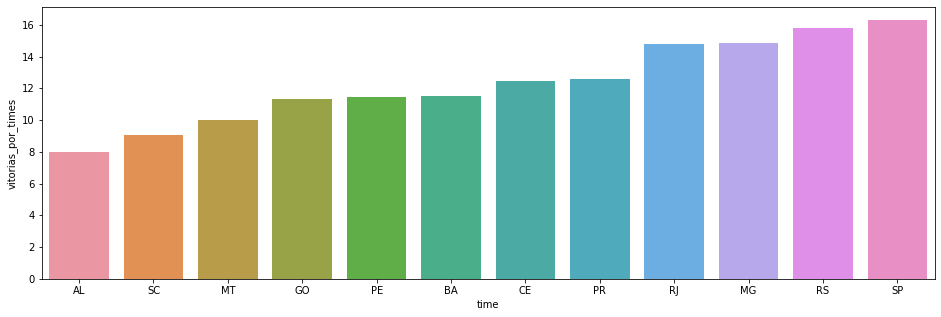

In [42]:
plt.figure(figsize=(16,5));
sns.barplot(x = df_aux5.sort_values('vitorias_por_times').time, y = df_aux5.sort_values('vitorias_por_times').vitorias_por_times, );

<b> Constatações </b>
- No agregado geral, SP tem a liderança, seguido por RS e MG;
- Já RJ, ocupa a 4a posição, mesmo tendo quase sempre mais times no campeonato que RS e MG.

## 3.4 Distrbuição dos Gols

### 3.4.1 Overview 

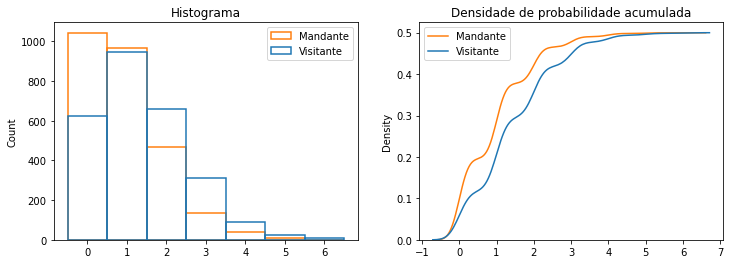

In [43]:
plt.figure(figsize=(12,4));
plt.subplot(1,2,1);
sns.histplot(data=df3_full[['mandante_placar', 'visitante_placar']], discrete=True, binwidth=0.5, fill=False );
plt.legend(['Mandante', 'Visitante']);
plt.title('Histograma');
plt.subplot(1,2,2);
sns.kdeplot(data=df3_full[['mandante_placar', 'visitante_placar']], cumulative=True);
plt.legend(['Mandante', 'Visitante']);
plt.title('Densidade de probabilidade acumulada');

<b> Constatações </b>
- Os mandantes fazem gol com mais frequência que os visitantes;
- Mas as chances de fazer de 2 gols em diante maior para os visitantes.

### 3.4.2  Gols por Rodada ao Longo das Temporadas

In [44]:
df3_full.loc[:, 'total_de_gols'] = df3_full['mandante_placar'] + df3_full['visitante_placar']
df_aux = pd.DataFrame(df3_full.groupby(['temporada', 'rodada']).sum()['total_de_gols']).reset_index()

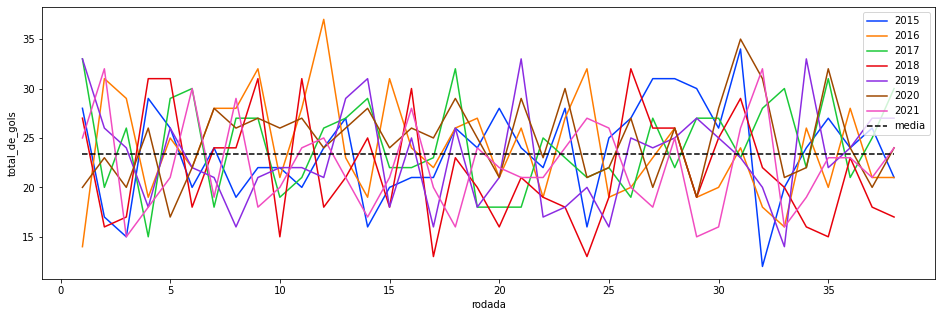

In [45]:
plt.figure(figsize=(16,5));
sns.lineplot(y=df_aux.total_de_gols, x=df_aux.rodada, hue=df_aux.temporada, palette='bright');
plt.hlines(df_aux.total_de_gols.mean(), xmin = 1, xmax=38, color='black', label='media', linestyle='dashed');
plt.legend();

<b> Constatações </b>
- A rodada do campeonato não aparenta influenciar o número de gols;

## 3.5 Chutes 

Algumas estatísticas ainda estão zeradas em cerca de 50 partidas. Elas serão filtradas aqui.

In [46]:
len(df3_stats[df3_stats['chutes'] == 0])

50

In [47]:
len(df3_stats[df3_stats['passes'] == 0])

50

In [48]:
df_aux_stats = df3_stats[df3_stats.passes != 0]

### 3.5.1 Overview 

<b>Top 10 maiores chutadores<b>

In [49]:
print('Top 10 em chutes por partida')
df_aux_stats.groupby('clube').mean().sort_values('chutes', ascending=False).head(10)['chutes']

Top 10 em chutes por partida


clube
Flamengo       14.743396
Atletico-MG    14.434615
Bragantino     14.381579
Palmeiras      14.034091
Cruzeiro       13.839572
Vitoria        13.315789
Gremio         13.287879
Bahia          13.200000
Sao Paulo      12.912879
Ceara          12.881579
Name: chutes, dtype: float64

<b>Top 10 chutadores mais precisos<b>

In [50]:
print('Top 10 em chutes no alvo por partida')
df_aux_stats.groupby('clube').mean().sort_values('chutes_no_alvo', ascending=False).head(10)['chutes_no_alvo']

Top 10 em chutes no alvo por partida


clube
Bragantino     4.618421
Bahia          4.426316
Ceara          4.223684
Fortaleza      4.061947
Flamengo       3.973585
Atletico-GO    3.561404
Atletico-MG    3.538462
Palmeiras      3.518939
Juventude      3.421053
Cuiaba         3.394737
Name: chutes_no_alvo, dtype: float64

<b> Constatações </b>
- Flamengo e Atlético-MG são os times que mais chutaram ao gol por partidas jogadas;
- Bragantino e Bahia são os times que tem maior precisão no chute.

### 3.5.2 Chutes por Todos os Times ao Longo das Rodadas para Cada Temporada

In [51]:
# criando uma feature para temporada e mudando a posicao dela e da data
df_aux_stats.loc[:,'temporada'] = df_aux_stats.apply(season, axis = 1)
df_aux = df_aux_stats[['data']]
df_aux_stats = df_aux_stats.drop('data', axis = 1)
df_aux_stats.insert(3, 'data', df_aux)

/tmp/ipykernel_18438/2575306210.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aux_stats.loc[:,'temporada'] = df_aux_stats.apply(season, axis = 1)


In [52]:
df_aux = pd.DataFrame(df_aux_stats.groupby(['temporada', 'rodada']).mean()['chutes']).reset_index()

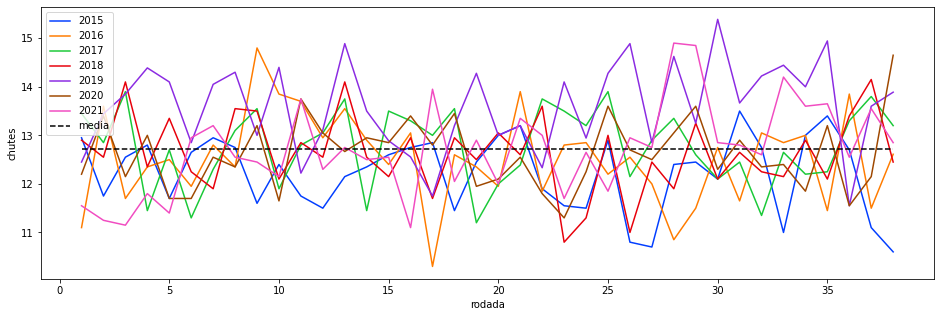

In [53]:
plt.figure(figsize=(16,5));
sns.lineplot(y=df_aux.chutes, x=df_aux.rodada, hue=df_aux.temporada, palette='bright');
plt.hlines(df_aux.chutes.mean(), xmin = 1, xmax=38, color='black', label='media', linestyle='dashed');
plt.legend();

In [54]:
print('Estatísticas dos chutes por temporada')
df_aux[df_aux.temporada != 2014].groupby('temporada')['chutes'].describe()

Estatísticas dos chutes por temporada


,count,mean,std,min,25%,50%,75%,max
temporada,,,,,,,,
2015,38.0,12.223684,0.773876,10.60,11.625000,12.425000,12.787500,13.500000
2016,38.0,12.525292,0.926860,10.30,11.950000,12.575000,12.987500,14.800000
2017,38.0,12.766813,0.792442,11.20,12.212500,12.875000,13.425000,13.900000
2018,38.0,12.630263,0.786073,10.80,12.150000,12.550000,13.037500,14.150000
2019,38.0,13.589547,0.918254,11.55,12.958333,13.633333,14.277778,15.388889
2020,38.0,12.620175,0.721747,11.30,12.150000,12.550000,13.050000,14.650000
2021,38.0,12.709211,0.929462,11.10,12.075000,12.700000,13.150000,14.900000


<b> Constatações <b>
- Visualmente, o ano de 2019 a maior média de chutes ao gol em geral;
- 2016, 2019 e 2021 vem maior variabilidade no número de chutes;
- Visualmente as estatísticas estão bem próximas ao longo destes anos.

## 3.6 Faltas 

In [55]:
print('Top 10 na média do n. de faltas por jogo')
df3_stats.groupby('clube').mean().sort_values('faltas', ascending=False).head(10)['faltas']

Top 10 na média do n. de faltas por jogo


clube
Vitoria          17.622807
Figueirense      17.539474
Ponte Preta      16.798246
Coritiba         16.605263
Joinville        16.578947
Palmeiras        16.334586
Internacional    16.131579
Chapecoense      15.929515
Atletico-GO      15.912281
Bahia            15.878947
Name: faltas, dtype: float64

## 3.7 Cartões Amarelos e Cartões Vermelhos

In [56]:
print('Top 10 na média do n. de cartões amarelos por jogo')
df3_stats.groupby('clube').mean().sort_values('cartao_amarelo', ascending=False).head(10)['cartao_amarelo']

Top 10 na média do n. de cartões amarelos por jogo


clube
Vitoria          2.666667
Figueirense      2.592105
Coritiba         2.585526
Vasco            2.584211
Parana           2.578947
Internacional    2.557018
Ponte Preta      2.491228
Joinville        2.473684
Goias            2.429825
Avai             2.412281
Name: cartao_amarelo, dtype: float64

In [57]:
print('Top 10 na média do n. de cartões vermelhos por jogo')
df3_stats.groupby('clube').mean().sort_values('cartao_vermelho', ascending=False).head(10)['cartao_vermelho']

Top 10 na média do n. de cartões vermelhos por jogo


clube
Parana           0.236842
Joinville        0.210526
Vasco            0.178947
Internacional    0.175439
Vitoria          0.175439
Figueirense      0.171053
Santa Cruz       0.157895
Fortaleza        0.157895
Avai             0.157895
Cuiaba           0.157895
Name: cartao_vermelho, dtype: float64

# 4.0 Hipóteses 

Algumas hipóteses podem ajudar a determinar as melhores features e insights para construção dos modelos, tais como:
<ol>
    <li>O time que mais chuta a gol é o que faz mais gols;</li>
    <li>O time que mais chuta a gol é o mais vencedor;</li>
</ol>

In [58]:
df4_full = df3_full.copy()
df4_stats = df3_stats.copy()

In [59]:
df4_stats.columns.tolist()

['ID',
 'temporada',
 'rodada',
 'data',
 'clube',
 'chutes',
 'chutes_no_alvo',
 'posse_de_bola',
 'passes',
 'precisao_passes',
 'faltas',
 'cartao_amarelo',
 'cartao_vermelho',
 'impedimentos',
 'escanteios']

In [60]:
df4_full.columns.tolist()

['ID',
 'rodada',
 'data',
 'hora',
 'temporada',
 'dia',
 'mandante',
 'visitante',
 'formacao_mandante',
 'formacao_visitante',
 'tecnico_mandante',
 'tecnico_visitante',
 'vencedor',
 'arena',
 'mandante_placar',
 'visitante_placar',
 'mandante_estado',
 'visitante_estado',
 'estado_vencedor',
 'total_de_gols']

## 4.1 Funções Úteis

In [61]:
def add_attributes(df_stats, df_full):
    """
    This function merge some attributes from two differente df, considering home x away teams
    """
   
    columns = df_stats.columns.to_list()[3:-3]
           
    for row in range(len(df_full)):
        for column in columns:
            if (df_stats['ID'] == df_full.loc[row, 'ID']).any() & (df_stats['clube'] == df_full.loc[row, 'mandante']).any():
                df_full.loc[row, 'mandante_' + column] = df_stats[(df_stats['ID'] == df_full.loc[row, 'ID']) & (df_stats['clube'] == df_full.loc[row, 'mandante'])][column].values[0]
            else:
                df_full.loc[row, 'mandante_' + column] = np.nan
                
            if (df_stats['ID'] == df_full.loc[row, 'ID']).any() & (df_stats['clube'] == df_full.loc[row, 'visitante']).any():       
                df_full.loc[row, 'visitante_' + column] = df_stats[(df_stats['ID'] == df_full.loc[row, 'ID']) & (df_stats['clube'] == df_full.loc[row, 'visitante'])][column].values[0]
            else:
                df_full.loc[row, 'visitante_' + column] = np.nan
                

    return df_full

def win(row):  
    """
    Cria uma variavel auxiliar para contar as vitorias
    """
    if (row.index == 'mandante').any():
        if row['vencedor'] == 1:
            return 1
        else:
            return 0
        
    elif (row.index == 'visitante').any():
        if row['vencedor'] == 2:
            return 1
        else:
            return 0
    

In [62]:
df4 = add_attributes(df4_stats, df4_full)

In [63]:
df4.columns

Index(['ID', 'rodada', 'data', 'hora', 'temporada', 'dia', 'mandante',
       'visitante', 'formacao_mandante', 'formacao_visitante',
       'tecnico_mandante', 'tecnico_visitante', 'vencedor', 'arena',
       'mandante_placar', 'visitante_placar', 'mandante_estado',
       'visitante_estado', 'estado_vencedor', 'total_de_gols', 'mandante_data',
       'visitante_data', 'mandante_clube', 'visitante_clube',
       'mandante_chutes', 'visitante_chutes', 'mandante_chutes_no_alvo',
       'visitante_chutes_no_alvo', 'mandante_posse_de_bola',
       'visitante_posse_de_bola', 'mandante_passes', 'visitante_passes',
       'mandante_precisao_passes', 'visitante_precisao_passes',
       'mandante_faltas', 'visitante_faltas', 'mandante_cartao_amarelo',
       'visitante_cartao_amarelo'],
      dtype='object')

## 4.2 O time que mais chuta a gol é o que mais faz gols 

In [64]:
# removendo os problemas de valores zeros nos passes, que provavelmente indica registro incorreto também nos passes
df_aux4 = df4[(df4.mandante_passes != 0) | (df4.visitante_passes != 0)]

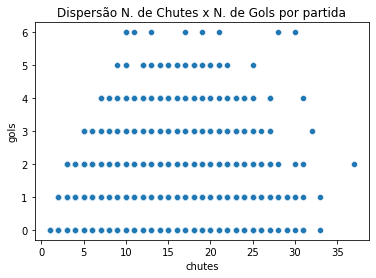

In [65]:
df_aux41 = pd.concat([df_aux4[['mandante', 'mandante_chutes', 'mandante_placar']] \
                      .rename(columns={'mandante': 'clube', 'mandante_chutes': 'chutes', 'mandante_placar': 'gols'}),\
                      df_aux4[['visitante', 'visitante_chutes', 'visitante_placar']] \
                      .rename(columns={'visitante': 'clube', 'visitante_chutes': 'chutes', 'visitante_placar': 'gols'})], axis=0)

sns.scatterplot(x=df_aux41.chutes, y=df_aux41.gols);
plt.title('Dispersão N. de Chutes x N. de Gols por partida');

In [66]:
df_aux41.corr()

,chutes,gols
chutes,1.000000,0.187737
gols,0.187737,1.000000


In [67]:
top_kicks_mean = df_aux41.groupby('clube').mean().sort_values('chutes', ascending=False)
top_kicks_sum = df_aux41.groupby('clube').sum().sort_values('gols', ascending=False)

In [68]:
print('Correlação entre as Médias')
top_kicks_mean.corr()

Correlação entre as Médias


,chutes,gols
chutes,1.000000,0.770229
gols,0.770229,1.000000


In [69]:
print('Correlação entre as somas')
top_kicks_sum.corr()

Correlação entre as somas


,chutes,gols
chutes,1.00000,0.98131
gols,0.98131,1.00000


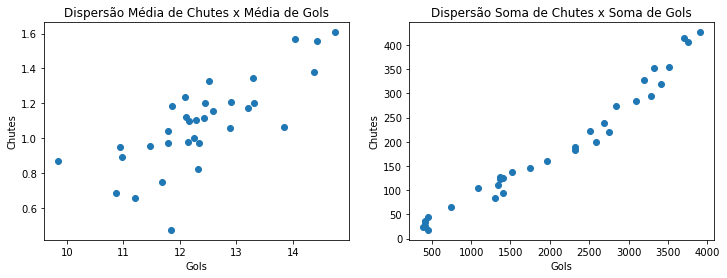

In [70]:
plt.figure(figsize=(12,4));

plt.subplot(1,2,1);
plt.scatter(x=top_kicks_mean.chutes, y=top_kicks_mean.gols);
plt.ylabel('Chutes');
plt.xlabel('Gols');
plt.title('Dispersão Média de Chutes x Média de Gols');


plt.subplot(1,2,2);
plt.scatter(x=top_kicks_sum.chutes, y=top_kicks_sum.gols);
plt.ylabel('Chutes');
plt.xlabel('Gols');
plt.title('Dispersão Soma de Chutes x Soma de Gols');

<b> Constatações </b>
- Numericamente, dadas as características do futebol em ser um jogo de baixa pontuação, não há correlação forte entre o número de chutes e o número de gols, quando os números são avaliados por partida.
- Entretanto, ao comparar os valores agregados pela média ou pela soma, nota-se que há forte correlação entre as duas variáveis.

<b> Conclusão: </b> parcialmente confirmada
- As evidências apontam que os times que mais chutam são os que possuem maior quantidade de gols marcados;
- Apesar de ser fraca a correlação por partida, este fator é decisivo em longo prazo (média e acumulado).

## 4.3 O time que é mais chuta é o mais vencedor

In [71]:
df_aux42_mandante = df_aux4[['temporada', 'mandante', 'vencedor']]
df_aux42_mandante.loc[:,'venceu'] = df_aux42_mandante.apply(win, axis = 1)

df_aux42_visitante = df_aux4[['temporada', 'visitante', 'vencedor']]
df_aux42_visitante.loc[:,'venceu'] = df_aux42_visitante.apply(win, axis = 1)

df_aux42_visitante = df_aux42_visitante.rename(columns={'visitante': 'clube'})
df_aux42_mandante = df_aux42_mandante.rename(columns={'mandante': 'clube'})

df_aux42 = pd.concat([df_aux42_mandante, df_aux42_visitante], axis=0).drop('vencedor', axis = 1)
df_aux42 = df_aux42.reset_index(drop=True)

/tmp/ipykernel_18438/636460711.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aux42_mandante.loc[:,'venceu'] = df_aux42_mandante.apply(win, axis = 1)
/tmp/ipykernel_18438/636460711.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aux42_visitante.loc[:,'venceu'] = df_aux42_visitante.apply(win, axis = 1)


In [72]:
# criando variaveis auxiliares e contando as vitorias
df_aux421 = pd.DataFrame(df_aux42.groupby(['temporada', 'clube']).value_counts()).reset_index()
df_aux421 = df_aux421[df_aux421['venceu'] == 1].rename(columns={0: 'n_vitorias'}).drop('venceu', axis = 1)
df_aux421 = df_aux421.groupby(['clube']).sum().drop('temporada', axis = 1)

In [73]:
df_aux_422 = pd.concat([df_aux421, top_kicks_sum.rename(columns={'chutes': 'chutes_sum'})[['chutes_sum']]], axis = 1)
df_aux_422.head()

,n_vitorias,chutes_sum
clube,,
America-MG,30,1405.0
Athletico-PR,97,3096.0
Atletico-GO,34,1344.0
Atletico-MG,127,3753.0
Avai,23,1308.0


In [74]:
df_aux_422.corr()

,n_vitorias,chutes_sum
n_vitorias,1.000000,0.971627
chutes_sum,0.971627,1.000000


<b> Conclusão: </b> confirmada.
- A variável da soma de chutes por time tem uma correlação forte com o número de vitórias, já que 

#  5.0 Feature Engineering

In [75]:
# Verificando se existem na no dataset
df3_full.isna().sum()[df3_full.isna().sum() > 0]

formacao_mandante     4
formacao_visitante    4
tecnico_mandante      1
tecnico_visitante     1
dtype: int64

In [76]:
df3_full.columns.tolist()

['ID',
 'rodada',
 'data',
 'hora',
 'temporada',
 'dia',
 'mandante',
 'visitante',
 'formacao_mandante',
 'formacao_visitante',
 'tecnico_mandante',
 'tecnico_visitante',
 'vencedor',
 'arena',
 'mandante_placar',
 'visitante_placar',
 'mandante_estado',
 'visitante_estado',
 'estado_vencedor',
 'total_de_gols']

In [77]:
# Optou-se aqui por remover estas features
df5 = df3_full.drop(['formacao_mandante',
                     'formacao_visitante',
                     'tecnico_mandante',
                     'tecnico_visitante',
                     #'mandante_placar',
                     #'visitante_placar',
                     'estado_vencedor',
                     'total_de_gols'], axis = 1)

Baseado no artigo referenciado abaixo, as seguintes features serão criadas:
- Número de vitórias na temporada;
- Número de derrotas do time na temporada;
- Número de empates do time na temporada;
- Número de vitórias do time em casa (%);
- Número de vitórias do time fora de casa (%);
- Número de empates do time em casa (%);
- Número de empates do time fora de casa (%);
- Número de derrotas do time em casa (%);
- Número de derrotas do time fora de casa (%);
- Sequência de vitórias em casa do time mandante;
- Sequência de vitórias em casa do time visitante;
- Sequência sem vitórias fora de casa do time mandante;
- Sequência sem vitórias fora de casa do time visitante;
- O time jogou na última temporada;
- Dias desde o último jogo;
- Gols marcados essa temporada jogando em casa;
- Gols marcados essa temporada jogando fora de casa;
- Gols sofridos essa temporada jogando em casa;
- Gols sofridos essa temporada jogando fora de casa;
- Número de vitórias do mandante contra o adversário;
- Número de vitórias do visitante contra o adversário.

## 5.1 Vitórias, Derrotas e Empates

In [78]:
pd.options.mode.chained_assignment = None

temporadas = df5['temporada'].value_counts().index.sort_values().values

df5['mandante_vitorias'] = df5['mandante']
df5['visitante_vitorias'] = df5['mandante']

df5['mandante_derrotas'] = df5['mandante']
df5['visitante_derrotas'] = df5['mandante']

df5['mandante_empates'] = df5['mandante']
df5['visitante_empates'] = df5['mandante']

for temporada in temporadas:
    dft = df5[df5['temporada'] == temporada]
    
    for index, row in dft.iterrows():
        df_home = dft[(dft['rodada'] < row['rodada']) & (dft['mandante'] == row['mandante'])]
        c1_wins = 0
        c1_loss = 0
        c1_draw = 0
        for index2, row2 in df_home.iterrows():
            if row2['vencedor'] == 0:
                c1_draw+=1
            elif row2['vencedor'] == 1:
                c1_wins+=1
            elif row2['vencedor'] == 2:
                c1_loss+=1

        df_away = dft[(dft['rodada'] < row['rodada']) & (dft['visitante'] == row['mandante'])]
        for index2, row2 in df_away.iterrows():
            if row2['vencedor'] == 1:
                c1_loss+=1                
            elif row2['vencedor'] == 0:
                c1_draw+=1
            elif row2['vencedor'] == 2:
                c1_wins+=1


        df_home = dft[(dft['rodada'] < row['rodada']) & (dft['mandante'] == row['visitante'])]
        c2_wins = 0
        c2_loss = 0
        c2_draw = 0
        for index2, row2 in df_home.iterrows():
            if row2['vencedor'] == 0:
                c2_draw+=1
            elif row2['vencedor'] == 1:
                c2_wins+=1                
            elif row2['vencedor'] == 2:
                c2_loss+=1

        df_away = dft[(dft['rodada'] < row['rodada']) & (dft['visitante'] == row['visitante'])]
        for index2, row2 in df_away.iterrows():
            if row2['vencedor'] == 1:
                c2_loss+=1                
            elif row2['vencedor'] == 0:
                c2_draw+=1
            elif row2['vencedor'] == 2:
                c2_wins+=1
                


        df5.at[index, 'mandante_vitorias'] = c1_wins
        df5.at[index, 'visitante_vitorias'] = c2_wins
        
        df5.at[index, 'mandante_derrotas'] = c1_loss
        df5.at[index, 'visitante_derrotas'] = c2_loss
        
        df5.at[index, 'mandante_empates'] = c1_draw
        df5.at[index, 'visitante_empates'] = c2_draw

In [79]:
df5.head()

,ID,rodada,data,hora,temporada,dia,mandante,visitante,vencedor,arena,mandante_placar,visitante_placar,mandante_estado,visitante_estado,mandante_vitorias,visitante_vitorias,mandante_derrotas,visitante_derrotas,mandante_empates,visitante_empates
0,4987,1,2015-05-09,18:32,2015,Sabado,Chapecoense,Coritiba,1,arena conda,2,1,SC,PR,0,0,0,0,0,0
1,4988,1,2015-05-09,18:33,2015,Sabado,Palmeiras,Atletico-MG,0,allianz parque,2,2,SP,MG,0,0,0,0,0,0
2,4989,1,2015-05-09,21:00,2015,Sabado,Fluminense,Joinville,1,maracana,1,0,RJ,SC,0,0,0,0,0,0
3,4990,1,2015-05-10,11:00,2015,Domingo,Gremio,Ponte Preta,0,arena do gremio,3,3,RS,SP,0,0,0,0,0,0
4,4991,1,2015-05-10,16:00,2015,Domingo,Athletico-PR,Internacional,1,estadio joaquim americo guimaraes,3,0,PR,RS,0,0,0,0,0,0


## 5.2 Vitórias, Derrotas e Empates como Mandante ou Visitante

In [80]:
def find_wins_home(ser):
    wins = [0]
    
    [wins.append(wins[-1]+1) if win==0 else wins.append(wins[-1]) for win in ser.values]
    
    return wins[0:-1]

def find_wins_away(ser):
    wins = [0]
    
    [wins.append(wins[-1]+1) if win==1 else wins.append(wins[-1]) for win in ser.values]
    
    return wins[0:-1]

def find_draws(ser):
    wins = [0]
    
    [wins.append(wins[-1]+1) if win==2 else wins.append(wins[-1]) for win in ser.values]
    
    return wins[0:-1]

df5['vitorias_como_mandante'] = df5.groupby(['temporada', 'mandante'])['vencedor'].transform(lambda x: find_wins_home(x))
df5['derrotas_como_mandante'] = df5.groupby(['temporada', 'mandante'])['vencedor'].transform(lambda x: find_wins_away(x))
df5['vitorias_como_visitante'] = df5.groupby(['temporada', 'visitante'])['vencedor'].transform(lambda x: find_wins_away(x))
df5['derrotas_como_visitante'] = df5.groupby(['temporada', 'visitante'])['vencedor'].transform(lambda x: find_wins_home(x))
df5['empates_como_mandante'] = df5.groupby(['temporada', 'mandante'])['vencedor'].transform(lambda x: find_draws(x)) 
df5['empates_como_visitante'] = df5.groupby(['temporada', 'visitante'])['vencedor'].transform(lambda x: find_draws(x))

## 5.3 Vitórias Seguidas

In [81]:
df5['vitorias_do_mandante'] = [1 if x == 0 else 0 for x in df5['vencedor'].values]
df5['vitorias_do_visitante'] = [1 if x == 1 else 0 for x in df5['vencedor'].values]

In [82]:
def find_streak(ser):
    streak = [0]
    
    [streak.append(streak[-1]+1) if win==1 else streak.append(0) for win in ser.values]
    
    return streak[0:-1]

df5['mandante_sequencia_vitorias'] =  df5.groupby(['temporada', 'mandante'])['vitorias_do_mandante'].transform(lambda x: find_streak(x))
df5['mandante_sequencia_derrotas'] =  df5.groupby(['temporada', 'mandante'])['vitorias_do_visitante'].transform(lambda x: find_streak(x))
df5['visitante_sequencia_vitorias'] = df5.groupby(['temporada', 'visitante'])['vitorias_do_visitante'].transform(lambda x: find_streak(x))
df5['visitante_sequencia_derrotas'] = df5.groupby(['temporada', 'visitante'])['vitorias_do_mandante'].transform(lambda x: find_streak(x))


## 5.4 Gols 

In [83]:
def find_goals(ser):
    goals = [0]
    
    [goals.append(goals[-1]+goal) for goal in ser.values]
    
    return goals[0:-1]

df5['gols_marcados_mandante'] =  df5.groupby(['temporada', 'mandante'])['mandante_placar'].transform(lambda x: find_goals(x))
df5['gols_sofridos_mandante'] =  df5.groupby(['temporada', 'mandante'])['visitante_placar'].transform(lambda x: find_goals(x))

df5['gols_marcados_visitante'] = df5.groupby(['temporada', 'visitante'])['visitante_placar'].transform(lambda x: find_goals(x))
df5['gols_sofridos_visitante'] = df5.groupby(['temporada', 'visitante'])['mandante_placar'].transform(lambda x: find_goals(x))

## 5.5 Dias Desde o Último Jogo

In [84]:
temporadas = df5['temporada'].value_counts().index.sort_values().values


df5['dias_entre_jogos_mandante'] = 0
df5['dias_entre_jogos_visitante'] = 0


for temporada in temporadas:
    dft = df5[df5['temporada'] == temporada]
    
    for index, row in dft.iterrows():
        dfc = dft[(dft['data'] <= row['data']) & ((dft['mandante'] == row['mandante']) | (dft['visitante'] == row['mandante']))]
        days_bet = ((dfc['data'] - dfc['data'].shift()).dt.days).values[-1]
        if math.isnan(days_bet):
            df5.at[index, 'dias_entre_jogos_mandante'] = 5
        else:
            df5.at[index, 'dias_entre_jogos_mandante'] = days_bet
            
        dfc = dft[(dft['data'] <= row['data']) & ((dft['mandante'] == row['visitante']) | (dft['visitante'] == row['visitante']))]
        days_bet_away = ((dfc['data'] - dfc['data'].shift()).dt.days).values[-1]
        if math.isnan(days_bet_away):
            df5.at[index, 'dias_entre_jogos_visitante'] = 5
        else:
            df5.at[index, 'dias_entre_jogos_visitante'] = days_bet_away

## 5.6 Subiu de Divisão? 

In [85]:
temporadas = df5['temporada'].value_counts().index.sort_values().values

df5['mandante_subiu'] = 0
df5['visitante_subiu'] = 0

for temporada in temporadas[1:]:
    dft = df5[df5['temporada'] == temporada]
    
    dfw = df5[df5['temporada'] == temporada-1]
    
    for index, row in dft.iterrows():
        last_year_clubs = dfw['mandante'].value_counts().index.sort_values().values
        
        home_club = row['mandante']
        if home_club in last_year_clubs:
            df5.at[index, 'mandante_subiu'] = 0
        else:
            df5.at[index, 'mandante_subiu'] = 1
        
        away_club = row['visitante']
        if away_club in last_year_clubs:
            df5.at[index, 'visitante_subiu'] = 0
        else:
            df5.at[index, 'visitante_subiu'] = 1

## 5.7 Confrontos Diretos 

In [86]:
df5['mandante_vitorias_contra_visitante'] = 0
df5['visitante_vitorias_contra_mandante'] = 0
df5['empates_historico'] = 0

clubs = df5['mandante'].value_counts().index.sort_values().values

for club1 in clubs:
    for club2 in clubs:
        dfc = df5[((df5['mandante'] == club1) & (df5['visitante'] == club2)) | ((df5['visitante'] == club1) & (df5['mandante'] == club2))]
        win_home = 0
        win_away = 0
        draws = 0
        for index, row in dfc.iterrows():
            df5.at[index, 'mandante_vitorias_contra_visitante'] = win_home
            df5.at[index, 'visitante_vitorias_contra_mandante'] = win_away
            df5.at[index, 'empates_historico'] = draws
            
            if row['vencedor'] == 0:
                win_home +=1
            elif row['vencedor'] == 1:
                win_away +=1
            else:
                draws+=1

## 5.8 Verificando Todas as Features

In [87]:
df5.head()

,ID,rodada,data,hora,temporada,dia,mandante,visitante,vencedor,arena,...,gols_sofridos_mandante,gols_marcados_visitante,gols_sofridos_visitante,dias_entre_jogos_mandante,dias_entre_jogos_visitante,mandante_subiu,visitante_subiu,mandante_vitorias_contra_visitante,visitante_vitorias_contra_mandante,empates_historico
0,4987,1,2015-05-09,18:32,2015,Sabado,Chapecoense,Coritiba,1,arena conda,...,0,0,0,5,5,0,0,0,0,0
1,4988,1,2015-05-09,18:33,2015,Sabado,Palmeiras,Atletico-MG,0,allianz parque,...,0,0,0,5,5,0,0,0,0,0
2,4989,1,2015-05-09,21:00,2015,Sabado,Fluminense,Joinville,1,maracana,...,0,0,0,5,5,0,0,0,0,0
3,4990,1,2015-05-10,11:00,2015,Domingo,Gremio,Ponte Preta,0,arena do gremio,...,0,0,0,5,5,0,0,0,0,0
4,4991,1,2015-05-10,16:00,2015,Domingo,Athletico-PR,Internacional,1,estadio joaquim americo guimaraes,...,0,0,0,5,5,0,0,0,0,0


In [88]:
df5.columns.tolist()

['ID',
 'rodada',
 'data',
 'hora',
 'temporada',
 'dia',
 'mandante',
 'visitante',
 'vencedor',
 'arena',
 'mandante_placar',
 'visitante_placar',
 'mandante_estado',
 'visitante_estado',
 'mandante_vitorias',
 'visitante_vitorias',
 'mandante_derrotas',
 'visitante_derrotas',
 'mandante_empates',
 'visitante_empates',
 'vitorias_como_mandante',
 'derrotas_como_mandante',
 'vitorias_como_visitante',
 'derrotas_como_visitante',
 'empates_como_mandante',
 'empates_como_visitante',
 'vitorias_do_mandante',
 'vitorias_do_visitante',
 'mandante_sequencia_vitorias',
 'mandante_sequencia_derrotas',
 'visitante_sequencia_vitorias',
 'visitante_sequencia_derrotas',
 'gols_marcados_mandante',
 'gols_sofridos_mandante',
 'gols_marcados_visitante',
 'gols_sofridos_visitante',
 'dias_entre_jogos_mandante',
 'dias_entre_jogos_visitante',
 'mandante_subiu',
 'visitante_subiu',
 'mandante_vitorias_contra_visitante',
 'visitante_vitorias_contra_mandante',
 'empates_historico']

As features <b>mandante_placar</b> e <b>visitante_placar</b> não devem estar preenchidas, pois estão disponíveis apenas após os jogos. Outras features relacionadas aos eventos da partida em si serão mantidas, pois mesmo que não estejam disponíveis no instante da previsão, poderão ser criados modelos específicos para elas.

In [89]:
df5 = df5.drop(['mandante_placar', 'visitante_placar', 'vitorias_do_mandante', 'vitorias_do_visitante'], axis = 1)

# 6.0 Data Transformation 

In [90]:
df6 = df5.copy()
df6 = df6.drop('ID', axis = 1)

In [91]:
df6.isna().sum()[df6.isna().sum() > 0]

Series([], dtype: int64)

## 6.1 Tipos 

In [92]:
df6.dtypes[df6.dtypes == 'object'].keys().tolist()

['hora',
 'dia',
 'mandante',
 'visitante',
 'arena',
 'mandante_estado',
 'visitante_estado',
 'mandante_vitorias',
 'visitante_vitorias',
 'mandante_derrotas',
 'visitante_derrotas',
 'mandante_empates',
 'visitante_empates']

In [93]:
# mandante_vitorias, visitante_vitorias, mandante_derrotas, visitante_derrotas, mandante_empates, visitante_empates podem ser int64
df6['mandante_vitorias'] = df6.mandante_vitorias.astype('int64')
df6['visitante_vitorias'] = df6.mandante_vitorias.astype('int64')
df6['mandante_derrotas'] = df6.mandante_derrotas.astype('int64')
df6['visitante_derrotas'] = df6.visitante_derrotas.astype('int64')
df6['mandante_empates'] = df6.mandante_empates.astype('int64')
df6['visitante_empates'] = df6.visitante_empates.astype('int64')

## 6.2 Natureza 

In [94]:
# lidando coma hora
df6.loc[:,'hora_decimal'] = pd.to_datetime(df6.hora).dt.hour + pd.to_datetime(df6.hora).dt.minute / 60
df6['hora_sin_'] = df6['hora_decimal'].apply(lambda x: np.sin(x * (2 * np.pi/24)))
df6['hora_cos_'] = df6['hora_decimal'].apply(lambda x: np.cos(x * (2 * np.pi/24)))
df6 = df6.drop(['hora', 'hora_decimal'], axis = 1)
df6.insert(5, 'hora_sin', df6.hora_sin_)
df6.insert(6, 'hora_cos', df6.hora_cos_)
df6 = df6.drop(['hora_sin_', 'hora_cos_'], axis = 1)
df6.head()

,rodada,data,temporada,dia,mandante,hora_sin,hora_cos,visitante,vencedor,arena,...,gols_sofridos_mandante,gols_marcados_visitante,gols_sofridos_visitante,dias_entre_jogos_mandante,dias_entre_jogos_visitante,mandante_subiu,visitante_subiu,mandante_vitorias_contra_visitante,visitante_vitorias_contra_mandante,empates_historico
0,1,2015-05-09,2015,Sabado,Chapecoense,-0.990268,0.139173,Coritiba,1,arena conda,...,0,0,0,5,5,0,0,0,0,0
1,1,2015-05-09,2015,Sabado,Palmeiras,-0.989651,0.143493,Atletico-MG,0,allianz parque,...,0,0,0,5,5,0,0,0,0,0
2,1,2015-05-09,2015,Sabado,Fluminense,-0.707107,0.707107,Joinville,1,maracana,...,0,0,0,5,5,0,0,0,0,0
3,1,2015-05-10,2015,Domingo,Gremio,0.258819,-0.965926,Ponte Preta,0,arena do gremio,...,0,0,0,5,5,0,0,0,0,0
4,1,2015-05-10,2015,Domingo,Athletico-PR,-0.866025,-0.500000,Internacional,1,estadio joaquim americo guimaraes,...,0,0,0,5,5,0,0,0,0,0


In [95]:
df6.dtypes[df6.dtypes == '<M8[ns]'].keys().tolist()

['data']

In [96]:
df6.dtypes

rodada                                         int64
data                                  datetime64[ns]
temporada                                      int64
dia                                           object
mandante                                      object
hora_sin                                     float64
hora_cos                                     float64
visitante                                     object
vencedor                                       int64
arena                                         object
mandante_estado                               object
visitante_estado                              object
mandante_vitorias                              int64
visitante_vitorias                             int64
mandante_derrotas                              int64
visitante_derrotas                             int64
mandante_empates                               int64
visitante_empates                              int64
vitorias_como_mandante                        

In [97]:
# hora e dia serão transformados utilizando relações trigonométricas
# month
df6['mes'] = df6['data'].dt.month
df6['mes_sin'] = df6['mes'].apply(lambda x: np.sin(x * (2 * np.pi/12)))
df6['mes_cos'] = df6['mes'].apply(lambda x: np.cos(x * (2 * np.pi/12)))
# day
df6['dia_do_mes'] = df6['data'].dt.day
df6['dia_do_mes_sin'] = df6['dia_do_mes'].apply(lambda x: np.sin(x * (2 * np.pi/30)))
df6['dia_do_mes_cos'] = df6['dia_do_mes'].apply(lambda x: np.cos(x * (2 * np.pi/30)))
# week of year
df6['semana_do_ano'] = df6['data'].dt.weekofyear
df6['semana_do_ano_sin'] = df6['semana_do_ano'].apply(lambda x: np.sin(x * (2 * np.pi/52)))
df6['semana_do_ano_cos'] = df6['semana_do_ano'].apply(lambda x: np.cos(x * (2 * np.pi/52)))

/tmp/ipykernel_18438/2216932869.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df6['semana_do_ano'] = df6['data'].dt.weekofyear


In [98]:
df6 = df6.drop(['mes', 'dia_do_mes', 'semana_do_ano'], axis = 1)

In [99]:
categorical = df6.dtypes[df6.dtypes == 'object'].keys().tolist()
df_categorical = df6[categorical]
numerics = df6.dtypes[(df6.dtypes == 'int64') | (df6.dtypes == 'float64')].keys().tolist()
numerics.remove('vencedor'); numerics.remove('temporada')
df_numerics = df6[numerics]
df_target = df6[['vencedor']]
df_temporada = df6[['temporada']]

## 6.3 Encoding 

In [100]:
df_categorical = pd.get_dummies(df_categorical)

## 6.4 Escala 

In [101]:
ss = StandardScaler()

In [102]:
df_numerics = pd.DataFrame(ss.fit_transform(df_numerics.values), columns = df_numerics.columns.tolist())
df_numerics.head()

,rodada,hora_sin,hora_cos,mandante_vitorias,visitante_vitorias,mandante_derrotas,visitante_derrotas,mandante_empates,visitante_empates,vitorias_como_mandante,...,visitante_subiu,mandante_vitorias_contra_visitante,visitante_vitorias_contra_mandante,empates_historico,mes_sin,mes_cos,dia_do_mes_sin,dia_do_mes_cos,semana_do_ano_sin,semana_do_ano_cos
0,-1.687006,-0.667244,0.117696,-1.370719,-1.370719,-1.400316,-1.380118,-1.432178,-1.426422,-1.228117,...,-0.454962,-0.800245,-0.960233,-0.757214,1.758753,-1.07702,1.320394,-0.395739,1.986769,-0.697683
1,-1.687006,-0.665172,0.125877,-1.370719,-1.370719,-1.400316,-1.380118,-1.432178,-1.426422,-1.228117,...,-0.454962,-0.800245,-0.960233,-0.757214,1.758753,-1.07702,1.320394,-0.395739,1.986769,-0.697683
2,-1.687006,0.283858,1.193351,-1.370719,-1.370719,-1.400316,-1.380118,-1.432178,-1.426422,-1.228117,...,-0.454962,-0.800245,-0.960233,-0.757214,1.758753,-1.07702,1.320394,-0.395739,1.986769,-0.697683
3,-1.687006,3.528278,-1.975339,-1.370719,-1.370719,-1.400316,-1.380118,-1.432178,-1.426422,-1.228117,...,-0.454962,-0.800245,-0.960233,-0.757214,1.758753,-1.07702,1.198025,-0.661765,1.986769,-0.697683
4,-1.687006,-0.249929,-1.092885,-1.370719,-1.370719,-1.400316,-1.380118,-1.432178,-1.426422,-1.228117,...,-0.454962,-0.800245,-0.960233,-0.757214,1.758753,-1.07702,1.198025,-0.661765,1.986769,-0.697683


In [103]:
df_numerics.columns.tolist()

['rodada',
 'hora_sin',
 'hora_cos',
 'mandante_vitorias',
 'visitante_vitorias',
 'mandante_derrotas',
 'visitante_derrotas',
 'mandante_empates',
 'visitante_empates',
 'vitorias_como_mandante',
 'derrotas_como_mandante',
 'vitorias_como_visitante',
 'derrotas_como_visitante',
 'empates_como_mandante',
 'empates_como_visitante',
 'mandante_sequencia_vitorias',
 'mandante_sequencia_derrotas',
 'visitante_sequencia_vitorias',
 'visitante_sequencia_derrotas',
 'gols_marcados_mandante',
 'gols_sofridos_mandante',
 'gols_marcados_visitante',
 'gols_sofridos_visitante',
 'dias_entre_jogos_mandante',
 'dias_entre_jogos_visitante',
 'mandante_subiu',
 'visitante_subiu',
 'mandante_vitorias_contra_visitante',
 'visitante_vitorias_contra_mandante',
 'empates_historico',
 'mes_sin',
 'mes_cos',
 'dia_do_mes_sin',
 'dia_do_mes_cos',
 'semana_do_ano_sin',
 'semana_do_ano_cos']

In [104]:
df_final = pd.concat([df_temporada, df_categorical, df_numerics, df_target], axis = 1)

In [105]:
df_final.columns.tolist()

['temporada',
 'dia_Domingo',
 'dia_Quarta-feira',
 'dia_Quinta-feira',
 'dia_Sabado',
 'dia_Segunda-feira',
 'dia_Sexta-feira',
 'dia_Terça-feira',
 'mandante_America-MG',
 'mandante_Athletico-PR',
 'mandante_Atletico-GO',
 'mandante_Atletico-MG',
 'mandante_Avai',
 'mandante_Bahia',
 'mandante_Botafogo-RJ',
 'mandante_Bragantino',
 'mandante_CSA',
 'mandante_Ceara',
 'mandante_Chapecoense',
 'mandante_Corinthians',
 'mandante_Coritiba',
 'mandante_Cruzeiro',
 'mandante_Cuiaba',
 'mandante_Figueirense',
 'mandante_Flamengo',
 'mandante_Fluminense',
 'mandante_Fortaleza',
 'mandante_Goias',
 'mandante_Gremio',
 'mandante_Internacional',
 'mandante_Joinville',
 'mandante_Juventude',
 'mandante_Palmeiras',
 'mandante_Parana',
 'mandante_Ponte Preta',
 'mandante_Santa Cruz',
 'mandante_Santos',
 'mandante_Sao Paulo',
 'mandante_Sport',
 'mandante_Vasco',
 'mandante_Vitoria',
 'visitante_America-MG',
 'visitante_Athletico-PR',
 'visitante_Atletico-GO',
 'visitante_Atletico-MG',
 'visitante

# 7.0 Machine Learning Models 

Os resultadodos de uma temporada são fortemente dependentes dos resultados da temporada anterior, já que boa parte dos jogadores e comissão técnica se mantém em curto prazo. Então aqui será utilizada uma estratégia para cross-validation que irá considerar o treinamento de modelos com base nos resultados de 1, 2 e 3 anos anteriores. A estatísticas de teste serão apresentadas como média e desvio-padrão destes períodos.

In [106]:
df7 = df_final.copy()

## 7.1 Funcões Úteis 

In [107]:
def cross_val_temps(n_temps_train, df, model):
    """
    Esta função faz cross-val com base no treinamento de n_temps_train temporadas anteriores
    e faz a predição de todos os resultados de uma temporada
    """
    temporadas = df.temporada.unique()
    df_metrics = pd.DataFrame()
    metrics = []
    
    for i, temporada in enumerate(temporadas):
        if (i > n_temps_train - 1) & (i < len(temporadas)):
            temps = []
            df_aux = pd.DataFrame()
            
            for j in range(i - n_temps_train, i):                
                temps.append(temporadas[j])                
                df_aux = pd.concat([df_aux, df[df.temporada == temporadas[j]]], axis = 0, ignore_index=True)
            #print(f'Temporada de Treino {temps}')
            #print(f'Temporada de Teste {temporada}')                
            
            X_train = df_aux.drop(['vencedor','temporada'], axis = 1).values
            y_train = df_aux['vencedor']            
            
            X_test = df[df.temporada == temporada].drop(['vencedor', 'temporada'], axis = 1).values
            y_test = df[df.temporada == temporada]['vencedor'].values
            
            model_selected = model.fit(X_train, y_train)
            y_hat = model_selected.predict(X_test)
            metrics.append(accuracy_score(y_hat, y_test))       
    
    return metrics

## 7.2 Logistic Regression

In [108]:
metrics_lg_1 = cross_val_temps(1, df7, LogisticRegression(max_iter = 500))
metrics_lg_2 = cross_val_temps(2, df7, LogisticRegression(max_iter = 500))
metrics_lg_3 = cross_val_temps(3, df7, LogisticRegression(max_iter = 500))

Text(0.5, 1.0, 'Acurácia por temporada de previsão')

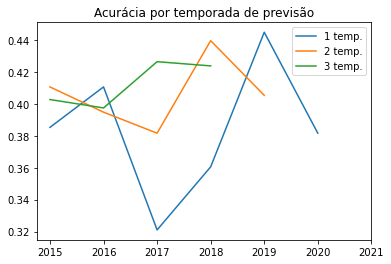

In [109]:
plt.plot(metrics_lg_1)
plt.plot(metrics_lg_2)
plt.plot(metrics_lg_3)
plt.xticks(ticks = np.arange(0, len(df7.temporada.unique())), labels = df7.temporada.unique());
plt.legend(['1 temp.', '2 temp.', '3 temp.']);
plt.title('Acurácia por temporada de previsão')

## 7.3 XGBoost 

In [110]:
metrics_xgb_1 = cross_val_temps(1, df7, xgb.XGBRFClassifier(n_estimators = 1000, use_label_encoder = False, eval_metric = 'mlogloss' ))
metrics_xgb_2 = cross_val_temps(2, df7, xgb.XGBRFClassifier(n_estimators = 1000, use_label_encoder = False, eval_metric = 'mlogloss' ))
metrics_xgb_3 = cross_val_temps(3, df7, xgb.XGBRFClassifier(n_estimators = 1000, use_label_encoder = False, eval_metric = 'mlogloss' ))

Text(0.5, 1.0, 'Acurácia por temporada de previsão')

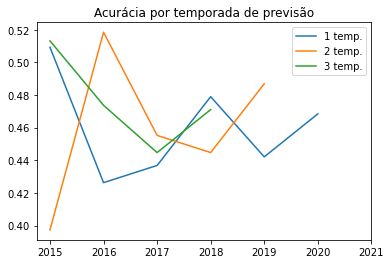

In [111]:
plt.plot(metrics_xgb_1)
plt.plot(metrics_xgb_2)
plt.plot(metrics_xgb_3)
plt.xticks(ticks = np.arange(0, len(df7.temporada.unique())), labels = df7.temporada.unique());
plt.legend(['1 temp.', '2 temp.', '3 temp.']);
plt.title('Acurácia por temporada de previsão')

## 7.4 Random Forest 

In [112]:
metrics_rf_1 = cross_val_temps(1, df7, RandomForestClassifier(n_estimators = 2000, n_jobs = -1, random_state = 42))
metrics_rf_2 = cross_val_temps(2, df7, RandomForestClassifier(n_estimators = 2000, n_jobs = -1, random_state = 42))
metrics_rf_3 = cross_val_temps(3, df7, RandomForestClassifier(n_estimators = 2000, n_jobs = -1, random_state = 42))

Text(0.5, 1.0, 'Acurácia por temporada de previsão')

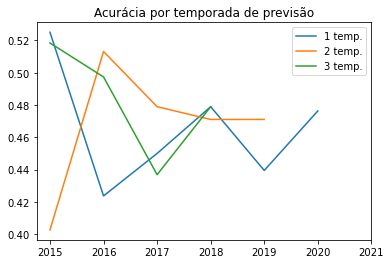

In [113]:
plt.plot(metrics_rf_1)
plt.plot(metrics_rf_2)
plt.plot(metrics_rf_3)
plt.xticks(ticks = np.arange(0, len(df7.temporada.unique())), labels = df7.temporada.unique());
plt.legend(['1 temp.', '2 temp.', '3 temp.']);
plt.title('Acurácia por temporada de previsão')

## 7.5 SVM 

In [114]:
metrics_svm_1 = cross_val_temps(1, df7,svm.SVC())
metrics_svm_2 = cross_val_temps(2, df7,svm.SVC())
metrics_svm_3 = cross_val_temps(3, df7,svm.SVC())

Text(0.5, 1.0, 'Acurácia por temporada de previsão')

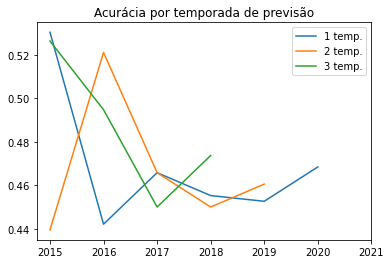

In [115]:
plt.plot(metrics_svm_1)
plt.plot(metrics_svm_2)
plt.plot(metrics_svm_3)
plt.xticks(ticks = np.arange(0, len(df7.temporada.unique())), labels = df7.temporada.unique());
plt.legend(['1 temp.', '2 temp.', '3 temp.']);
plt.title('Acurácia por temporada de previsão')

## 7.6 Resumo 

In [116]:
metrics = {
    'models': ['Logistic Regression', 'XGBoost', 'Random Forest', 'SVM'],
    
    'mean - 1. temp': [np.mean(metrics_lg_1), np.mean(metrics_xgb_1), np.mean(metrics_rf_1), np.mean(metrics_svm_1)],
    'std - 1. temp': [np.std(metrics_lg_1), np.std(metrics_xgb_1), np.std(metrics_rf_1), np.std(metrics_svm_1)],
    
    'mean - 2. temp': [np.mean(metrics_lg_2), np.mean(metrics_xgb_2), np.mean(metrics_rf_2), np.mean(metrics_svm_2)],
    'std - 2. temp': [np.std(metrics_lg_2), np.std(metrics_xgb_2), np.std(metrics_rf_2), np.std(metrics_svm_2)],

    'mean - 3. temp': [np.mean(metrics_lg_3), np.mean(metrics_xgb_3), np.mean(metrics_rf_3), np.mean(metrics_svm_3)],
    'std - 3. temp': [np.std(metrics_lg_3), np.std(metrics_xgb_3), np.std(metrics_rf_3), np.std(metrics_svm_3)],
}

df_metrics = pd.DataFrame(metrics)
df_metrics

,models,mean - 1. temp,std - 1. temp,mean - 2. temp,std - 2. temp,mean - 3. temp,std - 3. temp
0,Logistic Regression,0.383941,0.038543,0.406316,0.019309,0.412500,0.012672
1,XGBoost,0.460311,0.028415,0.460526,0.040768,0.475658,0.024431
2,Random Forest,0.465581,0.032945,0.467368,0.035913,0.482895,0.030033
3,SVM,0.469092,0.028733,0.467368,0.028323,0.486184,0.028059


Nota-se que o melhor modelo é o <b> SVM que considera 3 temporadas </b>, cujo valor médio e desvio-padrão da acurácia são os mais favoráveis.

# 8.0 Fine Tuning 

In [120]:
df8 = df7.copy()

## 8.1 Random Search 

In [145]:
params = {
    'C': [0.6, 1.0, 1.2, 1.4],
    'kernel': ['linear', 'rbf', 'sigmoid', 'poly'],
    'coef0': [0.0, 1.2, 1.4, 1.8, 2.2],
    'shrinking': [True, False],
    'decision_function_shape': ['ovr', 'ovo']  
}

In [147]:
final_result = pd.DataFrame()

for i in range(10):
   
    # escolhe os parâmetros aleatoriamente
    hp = {k: random.sample(v,1)[0] for k, v in params.items()}
    print(f'Index: {i}')
    print(hp)
    
    # model
    result = cross_val_temps(3, df8, svm.SVC(random_state = 42,
                                              C=hp['C'],
                                              kernel=hp['kernel'],
                                              coef0=hp['coef0'],
                                              shrinking=hp['shrinking'],
                                              decision_function_shape=hp['decision_function_shape']))

    
    # performance
    final_result = pd.concat([final_result, pd.DataFrame(result).T])

final_result = final_result.reset_index(drop=True)
final_result.rename(columns={0: '2018', 1: '2019', 2: '2020', 3: '2021'})

Index: 0
{'C': 1.2, 'kernel': 'rbf', 'coef0': 1.4, 'shrinking': False, 'decision_function_shape': 'ovo'}
Index: 1
{'C': 1.0, 'kernel': 'sigmoid', 'coef0': 1.2, 'shrinking': False, 'decision_function_shape': 'ovo'}
Index: 2
{'C': 1.2, 'kernel': 'poly', 'coef0': 1.2, 'shrinking': True, 'decision_function_shape': 'ovr'}
Index: 3
{'C': 1.4, 'kernel': 'rbf', 'coef0': 1.8, 'shrinking': False, 'decision_function_shape': 'ovr'}
Index: 4
{'C': 1.4, 'kernel': 'rbf', 'coef0': 1.4, 'shrinking': True, 'decision_function_shape': 'ovr'}
Index: 5
{'C': 1.4, 'kernel': 'rbf', 'coef0': 2.2, 'shrinking': False, 'decision_function_shape': 'ovr'}
Index: 6
{'C': 1.2, 'kernel': 'rbf', 'coef0': 0.0, 'shrinking': False, 'decision_function_shape': 'ovo'}
Index: 7
{'C': 0.6, 'kernel': 'sigmoid', 'coef0': 2.2, 'shrinking': True, 'decision_function_shape': 'ovr'}
Index: 8
{'C': 1.2, 'kernel': 'sigmoid', 'coef0': 1.4, 'shrinking': True, 'decision_function_shape': 'ovo'}
Index: 9
{'C': 1.0, 'kernel': 'linear', 'coef0

,2018,2019,2020,2021
0,0.521053,0.481579,0.457895,0.476316
1,0.331579,0.373684,0.294737,0.326316
2,0.326316,0.350000,0.410526,0.421053
3,0.507895,0.471053,0.447368,0.478947
4,0.507895,0.471053,0.447368,0.478947
5,0.507895,0.471053,0.447368,0.478947
6,0.521053,0.481579,0.457895,0.476316
7,0.478947,0.444737,0.439474,0.407895
8,0.463158,0.410526,0.300000,0.334211
9,0.426316,0.436842,0.442105,0.439474


In [148]:
final_result.T.describe().T.sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
0,4.0,0.484211,0.026578,0.457895,0.471711,0.478947,0.491447,0.521053
6,4.0,0.484211,0.026578,0.457895,0.471711,0.478947,0.491447,0.521053
3,4.0,0.476316,0.024965,0.447368,0.465132,0.475000,0.486184,0.507895
4,4.0,0.476316,0.024965,0.447368,0.465132,0.475000,0.486184,0.507895
5,4.0,0.476316,0.024965,0.447368,0.465132,0.475000,0.486184,0.507895
7,4.0,0.442763,0.029097,0.407895,0.431579,0.442105,0.453289,0.478947
9,4.0,0.436184,0.006921,0.426316,0.434211,0.438158,0.440132,0.442105
8,4.0,0.376974,0.073727,0.300000,0.325658,0.372368,0.423684,0.463158
2,4.0,0.376974,0.046053,0.326316,0.344079,0.380263,0.413158,0.421053
1,4.0,0.331579,0.032444,0.294737,0.318421,0.328947,0.342105,0.373684


<AxesSubplot:>

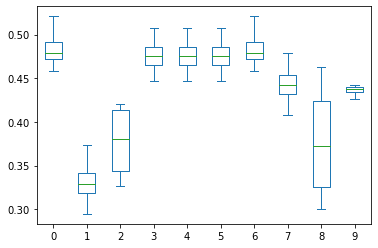

In [151]:
final_result.T.plot(kind='box')

Com base na tabela acima, vemos que a melhor média de acurácia ocorre no índice 0.

<b>{'C': 1.2, 'kernel': 'rbf', 'coef0': 1.4, 'shrinking': False, 'decision_function_shape': 'ovo'}</b>

In [155]:
df_model = df8[(df8.temporada == 2019) | (df8.temporada == 2020) | (df8.temporada == 2021)]
final_model = svm.SVC(C=1.2, kernel='rbf', coef0 = 1.4, shrinking=False, decision_function_shape='ovo')